In [67]:
# Python setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Sampler, Subset
from torchvision import models
import torch.nn as nn
from torch import optim, cuda
import torch
from datetime import datetime
import pandas as pd

In [2]:
# Setting up paths
base_path = Path('./clean_data/').absolute()
raw_base_path = base_path / 'motorcycles'
raw_train_path = str(raw_base_path / 'train')
raw_val_path = str(raw_base_path / 'val')
raw_test_path = str(raw_base_path / 'test')
square_base_path = base_path / 'square_motorcycles'
square_train_path = str(square_base_path / 'train')
square_val_path = str(square_base_path / 'val')
square_test_path = str(square_base_path / 'test')

In [187]:


def get_model(num_classes):
    '''
    Creates a resnet-50 pretrained model and replaces the classifier with a new classifier
    '''
    model = models.resnet34(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_inputs = model.fc.in_features
    model.fc = nn.Sequential(nn.Linear(num_inputs, 256),
                                       nn.ReLU(),
                                       # Get rid of dropout. I will re-evaluate later
                                       nn.Dropout(0.4),
                                       nn.Linear(256, num_classes),
                                       nn.LogSoftmax(dim=1))
    # Move to the GPU
    model = model.to('cuda')
    return model

In [171]:
def forward_pass(model, dataloader, criterion, num_images, clear_cuda_cache=True):
    '''
    Performs a forward pass getting loss and accuracy, without modifying the model
    model: A pytorch NN 
    data A pytorch Dataloader
    clear_cuda_cache: Do we want to clear cuda memory when possible?
    num_images: Int representing the number of images being processed. This is needed because
                a sampler might return fewer results than the total dataset.
    '''
    total_loss = 0
   
    with torch.no_grad():
        model.eval()
        
        for data, target in dataloader:
            data = data.to('cuda')
            target = target.to('cuda')
            result = model(data)
            loss = criterion(result, target)
            batch_loss = loss.item() * data.size(0)
            total_loss += batch_loss
            if clear_cuda_cache is True:
                data = None
                target = None
                cuda.empty_cache()
    mean_loss = total_loss / num_images
    return({'mean_loss': mean_loss})
        

In [174]:
def get_accuracy(model, dataloader, num_images, clear_cuda_cache=True):
    '''
    Performs a forward pass getting loss and accuracy, without modifying the model
    model: A pytorch NN 
    data A pytorch Dataloader
    clear_cuda_cache: Do we want to clear cuda memory when possible?
    num_images: Int representing the number of images being processed. This is needed because
                a sampler might return fewer results than the total dataset.
    '''
    
    correct_predictions = 0
    with torch.no_grad():
        model.eval()
        
        for data, target in dataloader:
            data = data.to('cuda')
            target = target.to('cuda')
            result = model(data)
            _, predicted = torch.max(result.data, 1)
            # Get accurate images
            correct_predictions += (predicted == target).sum().item()
            if clear_cuda_cache is True:
                data = None
                target = None
                cuda.empty_cache()
    return correct_predictions / num_images

In [192]:
# See https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ for hyperparameters
# hyper parameters are set to the research recommendations
def basic_train_model(dataloaders, epochs, clear_cuda_cache=True, name='basic model',
                      alpha=.001, beta1=0.9, beta2=0.999, epsilon=10e-8, weight_decay=0):
    '''
    Very-early training function. Not much here, but the basics to train the
    model and report loss and cuda memory
    dataloader: A Pytorch dataloader with train, validation and test datasets. All dataloaders
                should have the same number of classes
    clear_cuda_cache: Boolean telling us to clear the cuda cache when possible
    name: String with a name to give the model.
    '''
    start_time = datetime.now()
    results = []
    cuda_memory = []
    
    # The model changes with the number of classes, so we need to get that number.
    # A dataset with a sampler, may not include all classes in the dataset, so we
    # need to iterate to find the distinct classes
    # We also need the number of images, with the same constraints as classes. We
    # will calculate it here for accuracy
    included_classes = []
    num_images = 0
    for item in dataloaders['train']:
        included_classes = included_classes + item[1].tolist()
        num_images += len(item[1])
    num_classes = len(set(included_classes))
    
    # Get the number of val images returned in the dataloader. It could be a subset of the dataset if a sampler
    # is used
    num_val_images = 0
    for item in dataloaders['val']:
        num_val_images += len(item[1])
        
    # Get the number of images returned in the dataloader. It could be a subset of the dataset if a sampler
    # is used
    num_test_images = 0
    for item in dataloaders['test']:
        num_test_images += len(item[1])

    model = get_model(num_classes)

    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=alpha, betas=(beta1, beta2), 
                           eps=epsilon, weight_decay=weight_decay)

    for epoch in range(epochs):
        print(f'Epoch: {epoch + 1}')
        train_loss = 0.0
        for data, targets in dataloaders['train']:
            #Get cuda memory
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            data = data.to('cuda')
            targets = targets.to('cuda')
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            # Clear the gradients
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, targets)
            loss.backward()
            # Get loss for the batch
            batch_loss = loss.item() * data.size(0)
            train_loss += batch_loss
            optimizer.step()
            #Get cuda memory
            cuda_memory.append({
                'name': name,
                'timestamp': datetime.now(),
                'cuda_memory': cuda.memory_allocated()})
            # Clear the batch from cuda memory. It is no longer needed
            if clear_cuda_cache is True:
                data = None
                targets = None
                cuda.empty_cache()
        
        mean_train_loss = train_loss / num_images

        # Get train accuracy to see if the model is learning at all
        train_accuracy = get_accuracy(model, dataloaders['train'], num_images)
        # Get validation loss
       
        validation_results = forward_pass(model, dataloaders['val'], criterion, num_images=num_val_images,
                                          clear_cuda_cache=clear_cuda_cache)
        # Get test accuracy
        test_accuracy = get_accuracy(model, dataloaders['test'], num_test_images)
        
        print(f'Train_loss: {mean_train_loss}, Train accuracy: {train_accuracy}, Val loss: {validation_results["mean_loss"]}, Test Accuracy: {test_accuracy}')
        results.append({
            'epoch': epoch + 1,
            'train_loss': mean_train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': validation_results['mean_loss'],
            'test_accuracy': test_accuracy})
        
    end_time = datetime.now()
    return {'model': model, 'name': name, 'results': results, 'cuda_memory': cuda_memory, 
            'run_time': end_time - start_time}

In [7]:

batch_size = 256

basic_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as ResNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
basic_data = {
    'train': datasets.ImageFolder(root=raw_train_path, transform = basic_transforms['train'] ),
    'valid': datasets.ImageFolder(root=raw_val_path, transform = basic_transforms['valid']),
    'test': datasets.ImageFolder(root=raw_val_path, transform = basic_transforms['valid'])
}

basic_dataloaders = {
    'train': DataLoader(basic_data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(basic_data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(basic_data['test'], batch_size=batch_size, shuffle=True),
    
}


complex_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as imagenet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        # Normalize using same mean, std as ResNet
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
complex_data = {
    'train': datasets.ImageFolder(root=raw_train_path, transform = complex_transforms['train'] ),
    'valid': datasets.ImageFolder(root=raw_val_path, transform = complex_transforms['valid']),
     'test': datasets.ImageFolder(root=raw_val_path, transform = complex_transforms['valid'])
}

complex_dataloaders = {
    'train': DataLoader(complex_data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(complex_data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(complex_data['test'], batch_size=batch_size, shuffle=True)
}



In [117]:
class TargetSampler(Sampler):
    '''
    Sampler base on the number of targets we want. Rather than random sampling from all 
    targets, which may not have the same targets as test and train, we pull all images from 
    the first x number of targets
    
    This was extremely slow at first, because I was iterating through the data instead of 
    just the targets. Now it takes no noticable time

    '''
    def __init__(self, data, num_targets):
        '''
        data: A pytorch dataset (In this case, an ImageFolder)
        num_targets: Int representing the first X targets to use.
        '''
        self.num_targets = num_targets
        self.data = data
    
    def __iter__(self):
        indices = []
        for index, target in enumerate(self.data.targets):
            # Add the indice if the target is in range
            if target < self.num_targets:
                indices.append(index)
        return iter(indices)
    
    def __len__(self):
        # Count the number of images in the target range
        # The image is a tuple, with image[1] being the target
        return len([i for i in self.data.targets if i < self.num_targets])


In [8]:
raw_results_clear_cache = basic_train_model(dataloaders=basic_dataloaders, epochs=5, alpha=0.003,
                                            name='Basic images with basic transforms with clear', clear_cuda_cache=True)

complex_results_clear_cache = basic_train_model(dataloaders=complex_dataloaders, epochs=5, alpha=0.003,
                                            name='Basic images with complex transforms with clear', clear_cuda_cache=True)

Epoch: 1
Train_loss: 6.0177752143849945, Val loss: 5.899059706553275, Test Accuracy: 0.001455604075691412
Epoch: 2
Train_loss: 5.8988028732170825, Val loss: 5.901377439845945, Test Accuracy: 0.0
Epoch: 3
Train_loss: 5.898333211559003, Val loss: 5.9057129925168415, Test Accuracy: 0.002911208151382824
Epoch: 4
Train_loss: 5.894493939507612, Val loss: 5.913139906859641, Test Accuracy: 0.001455604075691412
Epoch: 5
Train_loss: 5.902565272793813, Val loss: 5.927647323414054, Test Accuracy: 0.002911208151382824
Epoch: 1
Train_loss: 6.006949440245511, Val loss: 5.9045275239791755, Test Accuracy: 0.001455604075691412
Epoch: 2
Train_loss: 5.911624171798964, Val loss: 5.922371058484873, Test Accuracy: 0.001455604075691412
Epoch: 3
Train_loss: 5.913269769695862, Val loss: 5.932730499139867, Test Accuracy: 0.001455604075691412
Epoch: 4
Train_loss: 5.904653520670917, Val loss: 5.940287569898358, Test Accuracy: 0.0
Epoch: 5
Train_loss: 5.89322919436332, Val loss: 5.948234551858694, Test Accuracy: 0.

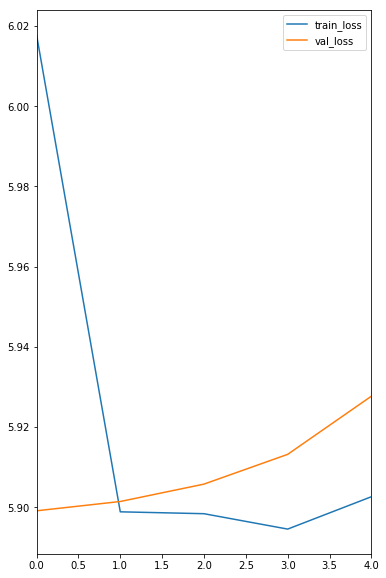

In [10]:
basic_results = pd.DataFrame(raw_results_clear_cache['results'])
basic_results.set_index('epoch')
basic_results.iloc[:,2:].plot(figsize=(6, 10))

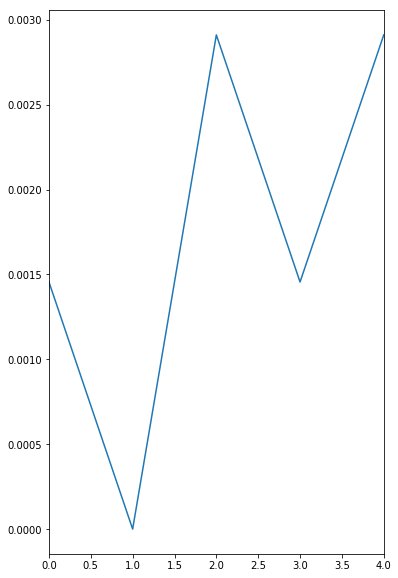

In [11]:
basic_results.iloc[:,1].plot(figsize=(6, 10))

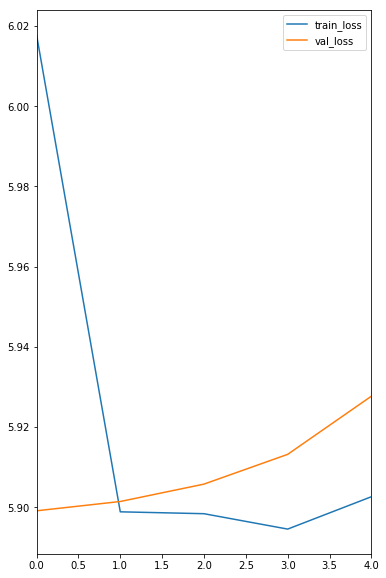

In [12]:
complex_results = pd.DataFrame(raw_results_clear_cache['results'])
complex_results.set_index('epoch')
complex_results.iloc[:,2:].plot(figsize=(6, 10))

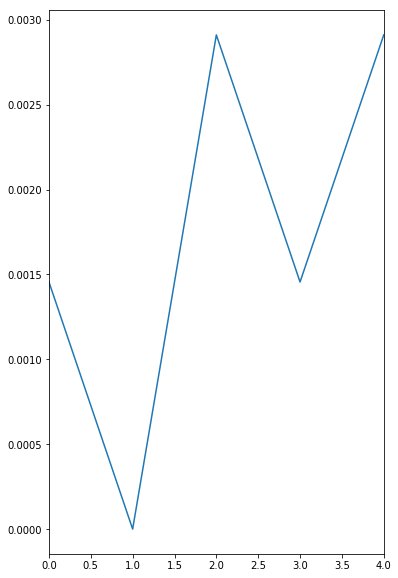

In [13]:
complex_results.iloc[:,1].plot(figsize=(6, 10))

Playing with less data, to improve ability to tune

In [183]:


train_sampler = TargetSampler(complex_data['train'], num_targets=2)
val_sampler = TargetSampler(complex_data['valid'], num_targets=2)
test_sampler = TargetSampler(complex_data['test'], num_targets=2)

ten_target_dataloaders = {
    'train': DataLoader(complex_data['train'], batch_size=128, sampler=train_sampler, shuffle=False),
    'val': DataLoader(complex_data['valid'], batch_size=128, sampler=val_sampler, shuffle=False),
    'test': DataLoader(complex_data['test'], batch_size=128, sampler=test_sampler, shuffle=False)
}


In [ ]:
ten_target_model = basic_train_model(dataloaders=ten_target_dataloaders, epochs=100, alpha=0.001,
                                     name='Ten targets', clear_cuda_cache=True)
print(ten_target_model['run_time'])

Epoch: 1
Train_loss: 0.7617332935333252, Train accuracy: 0.5, Val loss: 0.8120134472846985, Test Accuracy: 0.5
Epoch: 2
Train_loss: 0.7067155241966248, Train accuracy: 0.5, Val loss: 0.8339533805847168, Test Accuracy: 0.5
Epoch: 3
Train_loss: 0.6329320073127747, Train accuracy: 0.75, Val loss: 0.901364803314209, Test Accuracy: 0.5
Epoch: 4
Train_loss: 0.6384479999542236, Train accuracy: 0.875, Val loss: 0.9313985109329224, Test Accuracy: 0.0
Epoch: 5
Train_loss: 0.6002687811851501, Train accuracy: 0.75, Val loss: 0.9825594425201416, Test Accuracy: 0.0
Epoch: 6
Train_loss: 0.460521399974823, Train accuracy: 0.875, Val loss: 1.0649712085723877, Test Accuracy: 0.0
Epoch: 7
Train_loss: 0.5630374550819397, Train accuracy: 0.625, Val loss: 1.1700172424316406, Test Accuracy: 0.25
Epoch: 8
Train_loss: 0.5485527515411377, Train accuracy: 0.875, Val loss: 1.2096378803253174, Test Accuracy: 0.0
Epoch: 9
Train_loss: 0.5303010940551758, Train accuracy: 0.75, Val loss: 1.2620372772216797, Test Accur

In [168]:
ten_target_model['run_time']

datetime.timedelta(seconds=198, microseconds=84559)

In [170]:
included_classes = []
num_images = 0
for item in ten_target_dataloaders['train']:
    included_classes = included_classes + item[1].tolist()
    num_images += len(item[1])
num_classes = len(set(included_classes))